In [1]:
import os

os.chdir('/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/michael_dev/RA2_alpine_lads/ra_joint_predictions')

In [2]:
from utils.config import Config

config = Config()

In [11]:
from dataset.joint_damage_type_dataset import joint_damage_type_dataset
from dataset.joints.joint_extractor import default_joint_extractor, feet_joint_extractor, width_based_joint_extractor
from dataset.joints.joint_extractor_factory import get_joint_extractor

hands_narrowing = joint_damage_type_dataset(config, joint_extractor = get_joint_extractor('H', False))
hands_erosion = joint_damage_type_dataset(config, joint_extractor = get_joint_extractor('H', True))
feet_narrowing = joint_damage_type_dataset(config, joint_extractor = get_joint_extractor('F', False))
feet_erosion = joint_damage_type_dataset(config, joint_extractor = get_joint_extractor('F', True))

tf_hands_j_data = hands_narrowing.get_hands_joint_damage_type_dataset_with_validation(config.train_location + '/training.csv', joints_source = './data/predictions/hand_joint_data_train_v2.csv', joints_val_source = './data/predictions/hand_joint_data_test_v2.csv', erosion_flag = False)
tf_hands_e_data = hands_erosion.get_hands_joint_damage_type_dataset_with_validation(config.train_location + '/training.csv', joints_source = './data/predictions/hand_joint_data_train_v2.csv', joints_val_source = './data/predictions/hand_joint_data_test_v2.csv', erosion_flag = True)
tf_feet_j_data = feet_narrowing.get_feet_joint_damage_type_dataset_with_validation(config.train_location + '/training.csv', joints_source = './data/predictions/feet_joint_data_train_v2.csv', joints_val_source = './data/predictions/feet_joint_data_test_v2.csv', erosion_flag = False)
tf_feet_e_data = feet_erosion.get_feet_joint_damage_type_dataset_with_validation(config.train_location + '/training.csv', joints_source = './data/predictions/feet_joint_data_train_v2.csv', joints_val_source = './data/predictions/feet_joint_data_test_v2.csv', erosion_flag = True)

In [22]:
import tensorflow.keras as keras

hands_j_model = keras.models.load_model('../trained_models/hands_narrowing/v5/hands_narrowing_joint_damage_type_adamW_3e4_1e6_115steps_80_epochs_20wr.h5', compile = False)
hands_e_model = keras.models.load_model('../trained_models/hands_erosion/v5/hands_erosion_joint_damage_type_model_adamW_1e4_1e4_115steps_25wr.h5', compile = False)
feet_j_model = keras.models.load_model('../trained_models/feet_narrowing/v5/feet_narrowing_joint_damage_type_adamW_1e4_1e4_69steps_25wr.h5', compile = False)
feet_e_model = keras.models.load_model('../trained_models/feet_erosion/v5/feet_erosion_joint_damage_type_model_adamW_1e4_4e4_115steps_25wr.h5', compile = False)

In [14]:
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt

def print_metrics(model, ds, title, cutoff = 0.5):
    truths = []
    preds = []

    for x, y in ds[1]:
        y_pred = model.predict(x)[:, 0]
    
        truths.extend(y.numpy())
        preds.extend(y_pred)
    
    truths = np.array(truths)
    preds = np.array(preds)
    
    print('Brier', np.mean(np.square(truths - preds)))
    print('AUC', roc_auc_score(truths, preds))

    precs_0 = []
    recs_0 = []
    recs_1 = []
    
    cutoffs = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    
    for n in cutoffs:
        c_preds = np.zeros(preds.shape[0])
        c_preds[preds > n] = 1

        report = classification_report(truths, c_preds, output_dict = True)
        prec_0 = report['0.0']['precision']
        rec_0 = report['0.0']['recall']
        rec_1 = report['1.0']['recall']  
          
        precs_0.append(prec_0)
        recs_0.append(rec_0)
        recs_1.append(rec_1)
        
    plt.figure(figsize = (6, 4))
    plt.plot(cutoffs, precs_0, label = 'Precision 0')
    plt.plot(cutoffs, recs_0, label = 'Recall_0')
    plt.plot(cutoffs, recs_1, label = 'Recall 1')
    plt.plot([cutoff, cutoff], [0, 1])
    plt.grid()
    plt.title(title)
    plt.legend()
    plt.show()

Brier 0.04678916055119492
AUC 0.9559918926842949


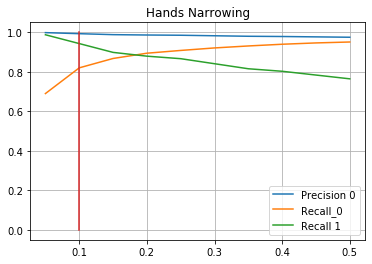

In [23]:
print_metrics(hands_j_model, tf_hands_j_data, 'Hands Narrowing', cutoff = 0.1)

Brier 0.08859855775761362
AUC 0.8137178946986893


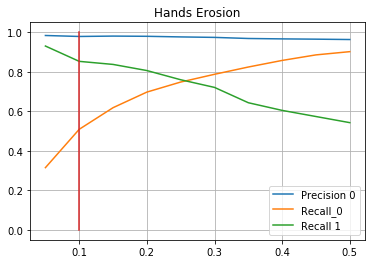

In [8]:
print_metrics(hands_e_model, tf_hands_e_data, 'Hands Erosion', cutoff = 0.1)

Brier 0.08282321573278599
AUC 0.8991335713223264


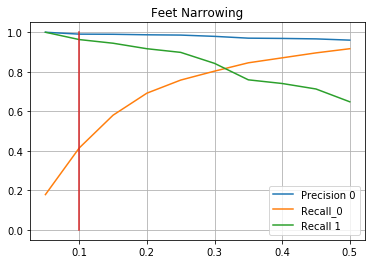

In [9]:
print_metrics(feet_j_model, tf_feet_j_data, 'Feet Narrowing', cutoff = 0.1)

Brier 0.10586763764271363
AUC 0.7903942307692308


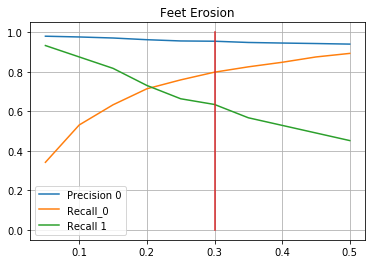

In [10]:
print_metrics(feet_e_model, tf_feet_e_data, 'Feet Erosion', cutoff = 0.3)